<a href="https://colab.research.google.com/github/ItaiBear/BearGAN/blob/main/MyGoodPanopticProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Using GAN to generate photorealistic images from semantic images

In [ ]:
import os
assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

In [ ]:
! pip install cloud-tpu-client==0.10 torch==1.11.0 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-1.11-cp37-cp37m-linux_x86_64.whl

In [ ]:
! pip install torchinfo
! pip install cityscapesscripts

In [ ]:
! git clone "https://github.com/ItaiBear/BearGAN"         
! git clone "https://github.com/boschresearch/OASIS"
! git clone "https://github.com/google-research/deeplab2.git"

fatal: destination path 'BearGAN' already exists and is not an empty directory.
fatal: destination path 'OASIS' already exists and is not an empty directory.
fatal: destination path 'deeplab2' already exists and is not an empty directory.


In [ ]:
#! pip install -r OASIS/requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [ ]:
root_project_directory = "/content/drive/MyDrive/ProjectGAN"

In [ ]:
import numpy as np
import random
import torch
from torchvision import transforms as TR
from torchinfo import summary
import matplotlib.pyplot as plt
from matplotlib import gridspec
from PIL import Image
from types import SimpleNamespace
import os
import sys
sys.path.append(os.path.abspath("/content/OASIS"))
sys.path.append(os.path.abspath("/content/BearGAN"))
sys.path.append(os.path.abspath("/content/deeplab2"))
print(sys.path)
import OASIS
import BearGAN


import models.models as models
import models.losses as losses
import dataloaders.dataloaders as dataloaders
import OASIS.utils.utils as utils
from OASIS.utils.fid_scores import fid_pytorch
import config

['', '/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython', '/content/OASIS', '/content/BearGAN', '/content/deeplab2']


ModuleNotFoundError: ignored

In [ ]:
!nvidia-smi

Sat May  7 21:24:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##Get pretrained checkpoints
I will save the trained models, available through dropbox, on the checkpoints folder on my google drive.

In [ ]:
do_fetch_checkpoints = True

In [ ]:
def fetch_checkpoints(dataset, checkpoint_dir):
  if (dataset == "cityscapes"):
    url = 'https://www.dropbox.com/sh/nf6of02pyk84zjg/AADUqkgPWsPKUZUPXHnaji-ma/oasis_cityscapes_pretrained.zip?dl=1'
    file_name = "oasis_cityscapes_pretrained.zip"
  elif (dataset == "coco"):
    url = "https://www.dropbox.com/sh/nf6of02pyk84zjg/AAD_fmyJJopzG23rwPK4n35Xa/oasis_coco_pretrained.zip?dl=1"
    file_name = "oasis_coco_pretrained.zip"
  elif (dataset == "ade20k"):
    url = "https://www.dropbox.com/sh/nf6of02pyk84zjg/AACpiAMaV-c4QcKv8DfiCv5-a/oasis_ade20k_pretrained.zip?dl=1"
    file_name = "oasis_ade20k_pretrained.zip"

  path = checkpoints_dir + "/" + file_name
  unzip_path = checkpoints_dir + "/" + dataset
  print(path)
  print("fetching checkpoints for the " + dataset + "dataset...")
  ! wget -c --read-timeout=5 --tries=0 -O {path} {url}
  print("unzipping...")
  ! unzip -q {path} -d {checkpoints_dir}
  print("finished successfuly!")


In [ ]:
if (do_fetch_checkpoints):
  checkpoints_dir = root_project_directory + "/pretrained_checkpoints"
  dataset_mode = "ade20k"
  fetch_checkpoints(dataset_mode, checkpoints_dir)

/content/drive/MyDrive/ProjectGAN/pretrained_checkpoints/oasis_ade20k_pretrained.zip
fetching checkpoints for the ade20kdataset...
--2022-04-27 10:58:38--  https://www.dropbox.com/sh/nf6of02pyk84zjg/AACpiAMaV-c4QcKv8DfiCv5-a/oasis_ade20k_pretrained.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/dl/nf6of02pyk84zjg/AACpiAMaV-c4QcKv8DfiCv5-a/oasis_ade20k_pretrained.zip [following]
--2022-04-27 10:58:38--  https://www.dropbox.com/sh/dl/nf6of02pyk84zjg/AACpiAMaV-c4QcKv8DfiCv5-a/oasis_ade20k_pretrained.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3b0b99c2c0b41d04abd3878722.dl.dropboxusercontent.com/cd/0/get/BkMU1uIo3pqLgNAKMe1HLlQCq2EfiB00jWE_zfMf_DvKS9VB_zt6_3ePGVTgi76k1SaCOyJuQu2jwSsXD1fVGLMvznpqkqOAgk_MB2jF

##retrieving the dataset
It is possible to use the downloader script of the cityscapes dataset.  
I have the cityscapes dataset on my google drive.  
Notice that the datset requires an approved account in order to download.

In [ ]:
download_dataset = False

In [ ]:
if download_dataset:
  cityscapes_dir = root_project_directory + "/datasets/cityscapes"
  ! csDownload leftImg8bit_trainvaltest.zip -d {cityscapes_dir}
  ! csDownload gtFine_trainvaltest.zip -d {cityscapes_dir}
  ! unzip -q {cityscapes_dir + "/gtFine_trainvaltest.zip"} -d {cityscapes_dir}
  ! unzip -q {cityscapes_dir + "/leftImg8bit_trainvaltest.zip"} -d {cityscapes_dir}

##Configure Arguments

Change the parameters that you want to change.

In [ ]:
def custom_arguments(opt):
  # user should change the default values of the options in this function
  # opt.dataset_mode=cityscapes
  opt.name = "my_cityscapes_panoptic"
  opt.segmentation = "panoptic"
  opt.continue_train = False
  opt.num_epochs = 2
  opt.gpu_ids= "-1"
  opt.no_EMA = True
  opt.freq_print = 100
  pass


#### Do not change

In [ ]:
def get_default_opt(train):
  #do not change these parameters
  opt = SimpleNamespace(
      #--- general options ---
      name="oasis_cityscapes_pretrained",                                     # name of the experiment. It decides where to store samples and models
      seed=42,                                                                # random seed
      segmentation="semantic",                                                # use semantic or panoptic segmentation for training
      gpu_ids='0',                                                            # gpu ids: e.g. 0  0,1,2, 0,2. use -1 for CPU
      checkpoints_dir=root_project_directory+"/pretrained_checkpoints",       # models are saved here
      no_spectral_norm=False,                                                 # this option deactivates spectral norm in all layers
      batch_size=1,                                                           # input batch size
      dataroot=root_project_directory+"/datasets/cityscapes",                 # path to dataset root
      dataset_mode="cityscapes",                                              # this option indicates which dataset should be loaded
      no_flip=False,                                                          # if specified, do not flip the images for data argumentation
      #--- generator options ---
      num_res_blocks=6,                                                       # number of residual blocks in G and D
      channels_G=64,                                                          # number of gen filters in first conv layer in generator
      param_free_norm="syncbatch",                                            # which norm to use in generator before SPADE
      spade_ks=3,                                                             # kernel size of convs inside SPADE
      no_EMA=False,                                                           # if specified, do *not* compute exponential moving averages
      EMA_decay=0.9999,                                                       # decay in exponential moving averages
      no_3dnoise=False,                                                       # if specified, do *not* concatenate noise to label maps
      z_dim=64)                                                               # dimension of the latent z vector
  
  if train:
    opt_extra = SimpleNamespace(
        freq_print=1000,                                                      # frequency of showing training results
        freq_save_ckpt=20000,                                                 # frequency of saving the checkpoints
        freq_save_latest=10000,                                               # frequency of saving the latest model
        freq_smooth_loss=250,                                                 # smoothing window for loss visualization
        freq_save_loss=2500,                                                  # frequency of loss plot updates
        freq_fid=5000,                                                        # frequency of saving the fid score (in training iterations)
        continue_train=True,                                                 # resume previously interrupted training
        which_iter='latest',                                                  # which epoch to load when continue_train
        num_epochs=10,                                                       # number of epochs to train
        beta1=0.0,                                                            # momentum term of adam
        beta2=0.999,                                                          # momentum term of adam
        lr_g=0.0001,                                                          # G learning rate
        lr_d=0.0004,                                                          # D learning rate

        channels_D=64,                                                        # number of discrim filters in first conv layer in discriminator
        add_vgg_loss=False,                                                   # if specified, add VGG feature matching loss
        lambda_vgg=10.0,                                                      # weight for VGG loss
        no_balancing_inloss=False,                                            # if specified, do *not* use class balancing in the loss function
        no_labelmix=False,                                                    # if specified, do *not* use LabelMix
        lambda_labelmix=10.0                                                  # weight for LabelMix regularization
    )
  else:
    opt_extra = SimpleNamespace(
        results_dir=root_project_directory+"/results/",                       # saves testing results here.
        ckpt_iter='best'                                                      # which epoch to load to evaluate a model
    )
  
  opt = SimpleNamespace(**opt.__dict__, **opt_extra.__dict__)       # conactenate all options
  opt.phase = 'train' if train else 'test'
  opt.loaded_latest_iter=None;
  
  return opt

In [ ]:
def set_dataset_default_lm(opt):
  #set default values based on given dataset
  if opt.dataset_mode == "ade20k":
      opt.lambda_labelmix=10.0
      opt.EMA_decay=0.9999
  if opt.dataset_mode == "cityscapes":
      opt.lr_g=0.0004
      opt.lambda_labelmix=5.0
      opt.freq_fid=2500
      opt.EMA_decay=0.999
  if opt.dataset_mode == "coco":
      opt.lambda_labelmix=10.0
      opt.EMA_decay=0.9999
      opt.num_epochs=100

#####hide

In [ ]:
import pickle

def configure_arguments(train=False):
  #set default values
  opt = get_default_opt(train)
  custom_arguments(opt)
  if train:
    set_dataset_default_lm(opt)
    if opt.continue_train:
      update_options_from_file(opt)
    custom_arguments(opt)
  

  utils.fix_seed(opt.seed)
  print_options(opt, train)
  if train:
    opt.loaded_latest_iter = 0 if not opt.continue_train else config.load_iter(opt)
  if train:
    save_options(opt, train)
  return opt

In [ ]:
# need to change the other functions
def update_options_from_file(opt):
  new_opt = config.load_options(opt)
  for k, v in sorted(vars(opt).items()):
    if hasattr(new_opt, k) and v != getattr(new_opt, k):
      new_val = getattr(new_opt, k)
      setattr(opt, k, new_val)


def print_options(opt, train):
    message = ''
    message += '----------------- Options ---------------\n'
    default_opt = get_default_opt(train)
    for k, v in sorted(vars(opt).items()):
        comment = ''
        
        default = getattr(default_opt, k)
        if v != default:
            comment = '\t[default: %s]' % str(default)
        message += '{:>25}: {:<30}{}\n'.format(str(k), str(v), comment)
    message += '----------------- End -------------------'
    print(message)

def save_options(opt, train):
    path_name = os.path.join(opt.checkpoints_dir,opt.name)
    os.makedirs(path_name, exist_ok=True)
    default_opt = get_default_opt(train)
    with open(path_name + '/opt.txt', 'wt') as opt_file:
        for k, v in sorted(vars(opt).items()):
            comment = ''
            default = getattr(default_opt, k)
            if v != default:
                comment = '\t[default: %s]' % str(default)
            opt_file.write('{:>25}: {:<30}{}\n'.format(str(k), str(v), comment))

    with open(path_name + '/opt.pkl', 'wb') as opt_file:
        pickle.dump(opt, opt_file)

#####tpu utils

In [ ]:
"""
import torch_xla.core.xla_model as xm
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.distributed.parallel_loader as pl

def put_on_multi_tpus(model, opt):
    if opt.gpu_ids != "-1":
        gpus = list(map(int, opt.gpu_ids.split(",")))
        model = DataParallelWithCallback(model, device_ids=gpus).cuda()
    else:
        model.module = model
    assert len(opt.gpu_ids.split(",")) == 0 or opt.batch_size % len(opt.gpu_ids.split(",")) == 0
    return model

train_sampler = torch.utils.data.distributed.DistributedSampler(
    train_dataset,
    num_replicas=xm.xrt_world_size(),
    rank=xm.get_ordinal(),
    shuffle=True)
  
test_sampler = torch.utils.data.distributed.DistributedSampler(
    test_dataset,
    num_replicas=xm.xrt_world_size(),
    rank=xm.get_ordinal(),
    shuffle=False)
"""

'\nimport torch_xla.core.xla_model as xm\nimport torch_xla.distributed.xla_multiprocessing as xmp\nimport torch_xla.distributed.parallel_loader as pl\n\ndef put_on_multi_tpus(model, opt):\n    if opt.gpu_ids != "-1":\n        gpus = list(map(int, opt.gpu_ids.split(",")))\n        model = DataParallelWithCallback(model, device_ids=gpus).cuda()\n    else:\n        model.module = model\n    assert len(opt.gpu_ids.split(",")) == 0 or opt.batch_size % len(opt.gpu_ids.split(",")) == 0\n    return model\n\ntrain_sampler = torch.utils.data.distributed.DistributedSampler(\n    train_dataset,\n    num_replicas=xm.xrt_world_size(),\n    rank=xm.get_ordinal(),\n    shuffle=True)\n  \ntest_sampler = torch.utils.data.distributed.DistributedSampler(\n    test_dataset,\n    num_replicas=xm.xrt_world_size(),\n    rank=xm.get_ordinal(),\n    shuffle=False)\n'

##Train the dataset

In [ ]:
def summarize_model():
  opt = configure_arguments(train=True)
  dataloader, dataloader_val = get_dataloaders(opt)
  model = models.OASIS_model(opt)
  image, label = models.preprocess_input(opt, iter(dataloader).next())
  print("Generator Summary:")
  #label.size() = [batch_size, opt.semantic_nc, h, w]
  print(summary(model.netG, label.size(), depth=7))
  print("Discriminator Summary:")
  print(summary(model.netD, image.size(), depth=7))

summarize_model()

----------------- Options ---------------
                EMA_decay: 0.999                         	[default: 0.9999]
             add_vgg_loss: False                         
               batch_size: 1                             
                    beta1: 0.0                           
                    beta2: 0.999                         
               channels_D: 64                            
               channels_G: 64                            
          checkpoints_dir: /content/drive/MyDrive/ProjectGAN/pretrained_checkpoints
           continue_train: False                         	[default: True]
                 dataroot: /content/drive/MyDrive/ProjectGAN/datasets/cityscapes
             dataset_mode: cityscapes                    
                 freq_fid: 2500                          	[default: 5000]
               freq_print: 1000                          
           freq_save_ckpt: 20000                         
         freq_save_latest: 10000               

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:405: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


Generator Summary:


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Layer (type:depth-idx)                             Output Shape              Param #
OASIS_Generator                                    --                        --
├─ModuleList: 1-1                                  --                        --
├─Conv2d: 1-2                                      [1, 1024, 8, 16]          913,408
├─ModuleList: 1-1                                  --                        --
│    └─ResnetBlock_with_SPADE: 2-1                 [1, 1024, 8, 16]          --
│    │    └─SPADE: 3-1                             [1, 1024, 8, 16]          --
│    │    │    └─SynchronizedBatchNorm2d: 4-1      [1, 1024, 8, 16]          --
│    │    │    └─Sequential: 4-2                   [1, 128, 8, 16]           --
│    │    │    │    └─Conv2d: 5-1                  [1, 128, 8, 16]           114,176
│    │    │    │    └─ReLU: 5-2                    [1, 128, 8, 16]           --
│    │    │    └─Conv2d: 4-3                       [1, 1024, 8, 16]          1,180,672
│    │    │    └─C

In [ ]:
#--- read options ---#
opt = configure_arguments(train=True)

#--- create utils ---#
timer = utils.timer(opt)
visualizer_losses = utils.losses_saver(opt)
losses_computer = losses.losses_computer(opt)
dataloader, dataloader_val = get_dataloaders(opt)
im_saver = utils.image_saver(opt)
fid_computer = fid_pytorch(opt, dataloader_val)   #problem with tpus

#--- create models ---#
print("creating models")
model = models.OASIS_model(opt)
model = models.put_on_multi_gpus(model, opt)

#--- create optimizers ---#
optimizerG = torch.optim.Adam(model.module.netG.parameters(), lr=opt.lr_g, betas=(opt.beta1, opt.beta2))
optimizerD = torch.optim.Adam(model.module.netD.parameters(), lr=opt.lr_d, betas=(opt.beta1, opt.beta2))

#--- the training loop ---#
already_started = False
start_epoch, start_iter = utils.get_start_iters(opt.loaded_latest_iter, len(dataloader))
for epoch in range(start_epoch, opt.num_epochs):
    for i, data_i in enumerate(dataloader):
        if not already_started and i < start_iter:
            continue
        already_started = True
        cur_iter = epoch*len(dataloader) + i
        image, label = models.preprocess_input(opt, data_i)

        #--- generator update ---#
        model.module.netG.zero_grad()
        loss_G, losses_G_list = model.forward(image, label, "losses_G", losses_computer)
        loss_G, losses_G_list = loss_G.mean(), [loss.mean() if loss is not None else None for loss in losses_G_list]
        loss_G.backward()
        optimizerG.step()

        #--- discriminator update ---#
        model.module.netD.zero_grad()
        loss_D, losses_D_list = model.forward(image, label, "losses_D", losses_computer)
        loss_D, losses_D_list = loss_D.mean(), [loss.mean() if loss is not None else None for loss in losses_D_list]
        loss_D.backward()
        optimizerD.step()

        #--- stats update ---#
        if not opt.no_EMA:
            utils.update_EMA(model, cur_iter, dataloader, opt)
        if cur_iter % opt.freq_print == 0:
            im_saver.visualize_batch(model, image, label, cur_iter)
            timer(epoch, cur_iter)
        if cur_iter % opt.freq_save_ckpt == 0:
            utils.save_networks(opt, cur_iter, model)
        if cur_iter % opt.freq_save_latest == 0:
            utils.save_networks(opt, cur_iter, model, latest=True)
        if cur_iter % opt.freq_fid == 0 and cur_iter > 0:
            is_best = fid_computer.update(model, cur_iter)
            if is_best:
                utils.save_networks(opt, cur_iter, model, best=True)
        visualizer_losses(cur_iter, losses_G_list+losses_D_list)

#--- after training ---#
utils.update_EMA(model, cur_iter, dataloader, opt, force_run_stats=True)
utils.save_networks(opt, cur_iter, model)
utils.save_networks(opt, cur_iter, model, latest=True)
is_best = fid_computer.update(model, cur_iter)
if is_best:
    utils.save_networks(opt, cur_iter, model, best=True)

print("The training has successfully finished")

----------------- Options ---------------
                EMA_decay: 0.999                         	[default: 0.9999]
             add_vgg_loss: False                         
               batch_size: 1                             
                    beta1: 0.0                           
                    beta2: 0.999                         
               channels_D: 64                            
               channels_G: 64                            
          checkpoints_dir: /content/drive/MyDrive/ProjectGAN/pretrained_checkpoints
           continue_train: False                         	[default: True]
                 dataroot: /content/drive/MyDrive/ProjectGAN/datasets/cityscapes
             dataset_mode: cityscapes                    
                 freq_fid: 2500                          	[default: 5000]
               freq_print: 100                           	[default: 1000]
           freq_save_ckpt: 20000                         
         freq_save_latest: 1000

/usr/local/lib/python3.7/dist-packages/torchvision/models/inception.py:48: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  FutureWarning,
Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth


  0%|          | 0.00/91.2M [00:00<?, ?B/s]

--- Now computing Inception activations for real set ---


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:424: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


--- Finished FID stats for real set ---
creating models
Created OASIS_Generator with 71107523 parameters
Created OASIS_Discriminator with 22251364 parameters


RuntimeError: ignored

##Generate from input  
Saves the generated images in the results directory.

In [ ]:

#--- read options ---#
opt = configure_arguments(train=False)

#--- create dataloader ---#
_, dataloader_val = dataloaders.get_dataloaders(opt)

#--- create utils ---#
image_saver = utils.results_saver(opt)
fid_computer = fid_pytorch(opt, dataloader_val)


#--- create models ---#
model = models.OASIS_model(opt)
model = models.put_on_multi_gpus(model, opt)
model.eval()

#--- caluculate fid ---#
#fid_score = fid_computer.compute_fid_with_valid_path(netG?, netEMA?)

#--- iterate over validation set ---#

for i, data_i in enumerate(dataloader_val):
    _, label = models.preprocess_input(opt, data_i)
    generated = model(None, label, "generate", None)
    image_saver(label, generated, data_i["name"])

Created CityscapesDataset, size train: 500, size val: 500
Created OASIS_Generator with 71107523 parameters


RuntimeError: ignored

##Visualize

In [ ]:
#f, axs = plt.subplots(1, 2, figsize=(16, 20))
image = opt.dataroot + "/leftImg8bit/val/frankfurt/frankfurt_000000_011810_leftImg8bit.png"
evaluated_path = os.path.join(opt.results_dir, opt.name, opt.ckpt_iter)
label = evaluated_path + "/label/frankfurt_000000_011810_leftImg8bit.png"
fake = evaluated_path + "/image/frankfurt_000000_011810_leftImg8bit.png"

plt.figure(figsize=(20, 4))
grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

plt.subplot(grid_spec[0])
plt.imshow(Image.open(label))
plt.axis('off')
plt.title('input label')

plt.subplot(grid_spec[1])
plt.imshow(Image.open(fake))
plt.axis('off')
plt.title('generated image')

plt.subplot(grid_spec[2])
plt.imshow(Image.open(image))
plt.axis('off')
plt.title('real image')


NameError: ignored

In [ ]:
! csViewer

qt.qpa.xcb: could not connect to display 
qt.qpa.plugin: Could not load the Qt platform plugin "xcb" in "" even though it was found.
This application failed to start because no Qt platform plugin could be initialized. Reinstalling the application may fix this problem.

Available platform plugins are: eglfs, linuxfb, minimal, minimalegl, offscreen, vnc, wayland-egl, wayland, wayland-xcomposite-egl, wayland-xcomposite-glx, webgl, xcb.



##Create Panoptic Images

In [ ]:
! csCreateTrainIdLabelImgs 
! csCreatePanopticImgs --dataset-folder {cityscapes_dir} --output-folder {cityscapes_dir} --
# not good because not all sections get an ID

In [ ]:
cityscapes_dir = os.path.join(root_project_directory, "/datasets/cityscapes/gtFine")


In [ ]:
%%shell
  # Set CITYSCAPES_DATASET to your dataset root.
  # Create train ID label images.
  CITYSCAPES_DATASET="/content/drive/MyDrive/ProjectGAN/datasets/cityscapes" csCreateTrainIdLabelImgs
  # To generate panoptic groundtruth, run the following command.
  CITYSCAPES_DATASET="/content/drive/MyDrive/ProjectGAN/datasets/cityscapes" csCreatePanopticImgs --use-train-id
  # [Optional] Generate panoptic groundtruth with EvalId to match evaluation
  # on the server. This step is not required for generating TFRecords.
  CITYSCAPES_DATASET="/content/drive/MyDrive/ProjectGAN/datasets/cityscapes" csCreatePanopticImgs

panoptic segmentation encoding taken from deeplab2: https://github.com/google-research/deeplab2/blob/main/data/build_cityscapes_data.py   


---


For panoptic segmentation, the encoded segmentation map will be the raw bytes of
a int32 panoptic map, where each pixel is assigned to a panoptic ID. Unlike the
ID used in Cityscapes script (`json2instanceImg.py`), this panoptic ID is
computed by:

```
  panoptic ID = semantic ID * label divisor + instance ID
```

where semantic ID will be:

*   ignore label (255) for pixels not belonging to any segment
*   for segments associated with `iscrowd` label:
    *   (default): ignore label (255)
    *   (if set `--treat_crowd_as_ignore=false` while running
        `build_cityscapes_data.py`): `category_id` (use TrainId)
*   `category_id` (use TrainId) for other segments
The instance ID will be 0 for pixels belonging to

*   `stuff` class
*   `thing` class with `iscrowd` label
*   pixels with ignore label

and `[1, label divisor)` otherwise.

In [ ]:
import tensorflow as tf
import json
import io
import collections
from PIL import ImageOps
#import deeplab2
from deeplab2.data import dataset
"""
DatasetDescriptor = collections.namedtuple(
    'DatasetDescriptor', [
        'dataset_name',  # Dataset name.
        'splits_to_sizes',  # Splits of the dataset into training, val and test.
        'num_classes',   # Number of semantic classes.
        'ignore_label',  # Ignore label value used for semantic segmentation.

        # Fields below are used for panoptic segmentation and will be None for
        # Semantic segmentation datasets.
        # Label divisor only used in panoptic segmentation annotation to infer
        # semantic label and instance id.
        'panoptic_label_divisor',
        # A tuple of classes that contains instance annotations. For example,
        # 'person' class has instance annotations while 'sky' does not.
        'class_has_instances_list',
        # A flag indicating whether the dataset is a video dataset that contains
        # sequence IDs and frame IDs.
        'is_video_dataset',
        # A string specifying the colormap that should be used for
        # visualization. E.g. 'cityscapes'.
        'colormap',
        # A flag indicating whether the dataset contains depth annotation.
        'is_depth_dataset',
        # The ignore label for depth annotations.
        'ignore_depth',
    ]
)

CITYSCAPES_COLORMAP = 'cityscapes'
_CITYSCAPES_PANOPTIC = 'cityscapes_panoptic'
CITYSCAPES_PANOPTIC_INFORMATION = DatasetDescriptor(
    dataset_name=_CITYSCAPES_PANOPTIC,
    splits_to_sizes={'train_fine': 2975,
                     'val_fine': 500,
                     'trainval_fine': 3475,
                     'test_fine': 1525},
    num_classes=19,
    ignore_label=255,
    panoptic_label_divisor=1000,
    class_has_instances_list=tuple(range(11, 19)),
    is_video_dataset=False,
    colormap=CITYSCAPES_COLORMAP,
    is_depth_dataset=False,
    ignore_depth=None,
)
"""
_NUM_SHARDS = 10
_SPLITS_TO_SIZES = dataset.CITYSCAPES_PANOPTIC_INFORMATION.splits_to_sizes
_IGNORE_LABEL = dataset.CITYSCAPES_PANOPTIC_INFORMATION.ignore_label
_CLASS_HAS_INSTANCE_LIST = dataset.CITYSCAPES_PANOPTIC_INFORMATION.class_has_instances_list
_PANOPTIC_LABEL_DIVISOR = dataset.CITYSCAPES_PANOPTIC_INFORMATION.panoptic_label_divisor

# A map from data type to folder name that saves the data.
_FOLDERS_MAP = {
    'image': 'leftImg8bit',
    'label': 'gtFine',
}

# A map from data type to filename postfix.
_POSTFIX_MAP = {
    'image': '_leftImg8bit',
    'label': '_gtFine_labelTrainIds',
}

# A map from data type to data format.
_DATA_FORMAT_MAP = {
    'image': 'png',
    'label': 'png',
}
_PANOPTIC_LABEL_FORMAT = 'raw'


###not needed currently

In [ ]:
def _get_images(cityscapes_root, dataset_split):
  """Gets files for the specified data type and dataset split.
  Args:
    cityscapes_root: String, path to Cityscapes dataset root folder.
    dataset_split: String, dataset split ('train', 'val', 'test')
  Returns:
    A list of sorted file names or None when getting label for
      test set.
  """
  search_files = os.path.join(cityscapes_root, "leftImg8bit", dataset_split, '*', "_leftImg8bit.png")
  filenames = tf.io.gfile.glob(search_files)
  return sorted(filenames)

In [ ]:
def _convert_dataset(cityscapes_root, dataset_split, output_dir, create_panoptic_data):
  """Converts the specified dataset split to TFRecord format.
  Args:
    cityscapes_root: String, path to Cityscapes dataset root folder.
    dataset_split: String, the dataset split (one of `train`, `val` and `test`).
    output_dir: String, directory to write output TFRecords to.
  Raises:
    RuntimeError: If loaded image and label have different shape, or if the
      image file with specified postfix could not be found.
  """
  image_files = _get_images(cityscapes_root, dataset_split)

  num_images = len(image_files)
  expected_dataset_size = 2975 if dataset_split == "train" else 500
  if num_images != expected_dataset_size:
    raise ValueError('Expects %d images, gets %d' %
                     (expected_dataset_size, num_images))
  segments_dict = None
  if create_panoptic_data:
    segments_dict = _read_segments(cityscapes_root, dataset_split)

  num_per_shard = int(math.ceil(len(image_files) / _NUM_SHARDS))
  #up here all good

  for shard_id in range(_NUM_SHARDS):
    shard_filename = '%s-%05d-of-%05d.tfrecord' % (
        dataset_split, shard_id, _NUM_SHARDS)
    output_filename = os.path.join(output_dir, shard_filename)
    with tf.io.TFRecordWriter(output_filename) as tfrecord_writer:
      start_idx = shard_id * num_per_shard
      end_idx = min((shard_id + 1) * num_per_shard, num_images)
      for i in range(start_idx, end_idx):
        # Read the image.
        with tf.io.gfile.GFile(image_files[i], 'rb') as f:
          image_data = f.read()

        if dataset_split == 'test':
          label_data, label_format = None, None
        elif FLAGS.create_panoptic_data:
          label_data, label_format = _create_panoptic_label(
              image_files[i], segments_dict)
        else:
          label_data, label_format = _create_semantic_label(image_files[i])

        # Convert to tf example.
        _, _, _, file_prefix = _split_image_path(image_files[i])
        example = data_utils.create_tfexample(image_data,
                                              _DATA_FORMAT_MAP['image'],
                                              file_prefix, label_data,
                                              label_format)

        tfrecord_writer.write(example.SerializeToString())


### create a panoptic segmentation for a single file

In [ ]:
def read_image(image_data):
  """Decodes image from in-memory data.
  Args:
    image_data: Bytes data representing encoded image.
  Returns:
    Decoded PIL.Image object.
  """
  image = Image.open(io.BytesIO(image_data))

  try:
    image = ImageOps.exif_transpose(image)    #keeps the image upright
  except TypeError:
    # capture and ignore this bug:
    # https://github.com/python-pillow/Pillow/issues/3973
    pass

  return image

In [ ]:
def _read_segments(cityscapes_root, dataset_split):
  """Reads segments information from json file.
  Args:
    cityscapes_root: String, path to Cityscapes dataset root folder.
    dataset_split: String, dataset split.
  Returns:
    segments_dict: A dictionary that maps `image_id` (common file prefix) to
      a tuple of (panoptic annotation file name, segments). Please refer to
      _generate_panoptic_label() method on the detail structure of `segments`.
  """
  json_filename = os.path.join(
      cityscapes_root, "gtFine", 'cityscapes_panoptic_%s_trainId.json' % dataset_split)
  with tf.io.gfile.GFile(json_filename) as f:
    panoptic_dataset = json.load(f)

  segments_dict = {}
  for annotation in panoptic_dataset['annotations']:
    image_id = annotation['image_id']
    if image_id in segments_dict:
      raise ValueError('Image ID %s already exists' % image_id)
    annotation_file_name = annotation['file_name']
    segments = annotation['segments_info']

    segments_dict[image_id] = (annotation_file_name, segments)
  return segments_dict

In [ ]:
def _split_image_path(image_path):
  """Helper method to extract split paths from input image path.
  Args:
    image_path: String, path to the image file.
  Returns:
    A tuple of (cityscape root, dataset split, cityname and shared filename
      prefix).
  """
  image_path = os.path.normpath(image_path)
  path_list = image_path.split(os.sep)
  image_folder, dataset_split, city_name, file_name = path_list[-4:]
  if image_folder != _FOLDERS_MAP['image']:
    raise ValueError('Expects image path %s containing image folder.'
                     % image_path)

  pattern = '%s.%s' % (_POSTFIX_MAP['image'], _DATA_FORMAT_MAP['image'])
  if not file_name.endswith(pattern):
    raise ValueError('Image file name %s should end with %s' %
                     (file_name, pattern))

  file_prefix = file_name[:-len(pattern)]
  return os.sep.join(path_list[:-4]), dataset_split, city_name, file_prefix

In [ ]:
def _generate_panoptic_label(panoptic_annotation_file, segments, treat_crowd_as_ignore):
  """Creates panoptic label map from annotations.
  Args:
    panoptic_annotation_file: String, path to panoptic annotation (populated
      with `trainId`).
    segments: A list of dictionaries containing information of every segment.
      Read from panoptic_${DATASET_SPLIT}_trainId.json. This method consumes
      the following fields in each dictionary:
        - id: panoptic id
        - category_id: semantic class id
        - area: pixel area of this segment
        - iscrowd: if this segment is crowd region
  Returns:
    A 2D numpy int32 array with the same height / width with panoptic
    annotation. Each pixel value represents its panoptic ID. Please refer to
    ../g3doc/setup/cityscapes.md for more details about how panoptic ID is
    assigned.
  """
  with tf.io.gfile.GFile(panoptic_annotation_file, 'rb') as f:
    panoptic_label = read_image(f.read())

  if panoptic_label.mode != 'RGB':
    raise ValueError('Expect RGB image for panoptic label, gets %s' %
                     panoptic_label.mode)

  panoptic_label = np.array(panoptic_label, dtype=np.int32)
  # Cityscapes panoptic map is created by:
  #   color = [segmentId % 256, segmentId // 256, segmentId // 256 // 256]
  panoptic_label = np.dot(panoptic_label, [1, 256, 256 * 256])

  semantic_label = np.ones_like(panoptic_label) * _IGNORE_LABEL
  instance_label = np.zeros_like(panoptic_label)
  # Running count of instances per semantic category.
  instance_count = collections.defaultdict(int)
  for segment in segments:
    selected_pixels = panoptic_label == segment['id']
    pixel_area = np.sum(selected_pixels)
    if pixel_area != segment['area']:
      raise ValueError('Expect %d pixels for segment %s, gets %d.' %
                       (segment['area'], segment, pixel_area))

    category_id = segment['category_id']
    semantic_label[selected_pixels] = category_id

    if category_id in _CLASS_HAS_INSTANCE_LIST:
      if segment['iscrowd']:
        # Cityscapes crowd pixels will have instance ID of 0.
        if treat_crowd_as_ignore:
          semantic_label[selected_pixels] = _IGNORE_LABEL
        continue
      # Non-crowd pixels will have instance ID starting from 1.
      instance_count[category_id] += 1
      if instance_count[category_id] >= _PANOPTIC_LABEL_DIVISOR:
        raise ValueError('Too many instances for category %d in this image.' %
                         category_id)
      instance_label[selected_pixels] = instance_count[category_id]
    elif segment['iscrowd']:
      raise ValueError('Stuff class should not have `iscrowd` label.')

  panoptic_label = semantic_label * _PANOPTIC_LABEL_DIVISOR + instance_label
  return panoptic_label.astype(np.int32)

In [ ]:
def _get_panoptic_annotation(cityscapes_root, dataset_split,
                             annotation_file_name):
  panoptic_folder = 'cityscapes_panoptic_%s_trainId' % dataset_split
  return os.path.join(cityscapes_root, _FOLDERS_MAP['label'], panoptic_folder, annotation_file_name)

In [ ]:
def _create_panoptic_label(image_path, segments_dict, treat_crowd_as_ignore=False):
  """Creates labels for panoptic segmentation."""
  cityscapes_root, dataset_split, _, file_prefix = _split_image_path(image_path)

  annotation_file_name, segments = segments_dict[file_prefix]
  #get the path to the cityscapesscript trainID annotated panoptic segmentation
  panoptic_annotation_file = _get_panoptic_annotation(cityscapes_root,
                                                      dataset_split,
                                                      annotation_file_name)

  panoptic_label = _generate_panoptic_label(panoptic_annotation_file, segments, treat_crowd_as_ignore)
  return panoptic_label.tostring(), _PANOPTIC_LABEL_FORMAT

##dataloaders

In [ ]:
def preprocess_input(opt, data):
    data['label'] = data['label'].long()
    if opt.gpu_ids != "-1":
        data['label'] = data['label'].cuda()
        data['image'] = data['image'].cuda()
    label_map = data['label']
    bs, _, h, w = label_map.size()
    nc = opt.semantic_nc
    if opt.gpu_ids != "-1":
        input_label = torch.cuda.FloatTensor(bs, nc, h, w).zero_()
    else:
        input_label = torch.FloatTensor(bs, nc, h, w).zero_()
    input_semantics = input_label.scatter_(1, label_map, 1.0)
    return data['image'], input_semantics

In [ ]:
opt = configure_arguments(train=True)
dataloader, dataloader_val = get_dataloaders(opt)
data_i = next(iter(dataloader))
#image, label = models.preprocess_input(opt, data_i) #need to change preprocess for panoptic.

----------------- Options ---------------
                EMA_decay: 0.999                         	[default: 0.9999]
             add_vgg_loss: False                         
               batch_size: 1                             
                    beta1: 0.0                           
                    beta2: 0.999                         
               channels_D: 64                            
               channels_G: 64                            
          checkpoints_dir: /content/drive/MyDrive/ProjectGAN/pretrained_checkpoints
           continue_train: False                         	[default: True]
                 dataroot: /content/drive/MyDrive/ProjectGAN/datasets/cityscapes
             dataset_mode: cityscapes                    
                 freq_fid: 2500                          	[default: 5000]
               freq_print: 100                           	[default: 1000]
           freq_save_ckpt: 20000                         
         freq_save_latest: 1000

NotFoundError: ignored

panoptic is just instance in COCO format ☹

Text(0.5, 1.0, 'panoptic')

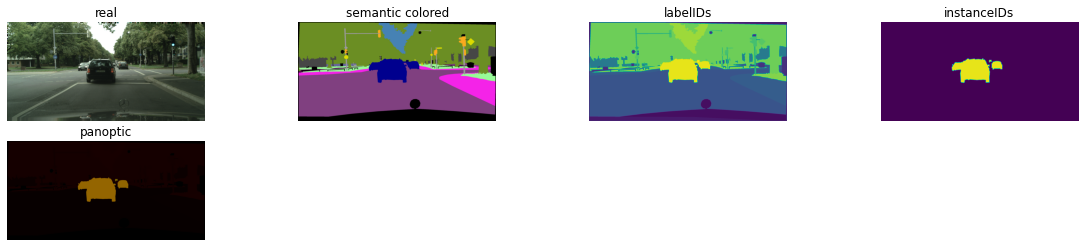

In [ ]:
from numpy.lib.type_check import real_if_close
real = np.array(Image.open(opt.dataroot + "/leftImg8bit/train/hanover/hanover_000000_000164_leftImg8bit.png"))
semantic = np.array(Image.open(opt.dataroot + "/gtFine/train/hanover/hanover_000000_000164_gtFine_color.png"))
labelIDs = np.array(Image.open(opt.dataroot + "/gtFine/train/hanover/hanover_000000_000164_gtFine_labelIds.png"))
instanceIDs = np.array(Image.open(opt.dataroot + "/gtFine/train/hanover/hanover_000000_000164_gtFine_instanceIds.png"))
panoptic = np.array(Image.open(opt.dataroot + "/gtFinePanoptic/cityscapes_panoptic_train/hanover_000000_000164_gtFine_panoptic.png"), dtype=np.int32)

plt.figure(figsize=(20, 4))
grid_spec = gridspec.GridSpec(2, 4, width_ratios=[6, 6, 6, 6])

plt.subplot(grid_spec[0])
plt.imshow(real)
plt.axis('off')
plt.title('real')
plt.subplot(grid_spec[1])
plt.imshow(semantic)
plt.axis('off')
plt.title('semantic colored')
plt.subplot(grid_spec[2])
plt.imshow(labelIDs)
plt.axis('off')
plt.title('labelIDs')
plt.subplot(grid_spec[3])
plt.imshow(instanceIDs)
plt.axis('off')
plt.title('instanceIDs')
plt.subplot(grid_spec[1,0])
plt.imshow(panoptic)
plt.axis('off')
plt.title('panoptic')

In [ ]:
from OASIS.dataloaders.dataloaders import get_dataset_name
def get_dataloaders(opt):
    #only city scapes is now supported for panoptic
    dataset_name   = get_dataset_name(opt.dataset_mode)
    if opt.segmentation == "semantic":
      file = __import__("dataloaders."+dataset_name)
      dataset_train = file.__dict__[dataset_name].__dict__[dataset_name](opt, for_metrics=False)
      dataset_val   = file.__dict__[dataset_name].__dict__[dataset_name](opt, for_metrics=True)
    else:
      print("getting panoptic datasets")
      dataset_train = CityscapesDataset(opt, for_metrics=False)
      dataset_val   = CityscapesDataset(opt, for_metrics=True)

    print("Created %s, size train: %d, size val: %d" % (dataset_name, len(dataset_train), len(dataset_val)))

    dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size = opt.batch_size, shuffle = True, drop_last=True)
    dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size = opt.batch_size, shuffle = False, drop_last=False)

    return dataloader_train, dataloader_val

In [ ]:
class CityscapesDataset(torch.utils.data.Dataset):
    def __init__(self, opt, for_metrics):
        opt.load_size = 512
        opt.crop_size = 512
        opt.label_nc = 34
        opt.contain_dontcare_label = True
        opt.semantic_nc = 35 # label_nc + unknown
        opt.cache_filelist_read = False
        opt.cache_filelist_write = False
        opt.aspect_ratio = 2.0

        if opt.segmentation == "panoptic":
          opt.segments_dict = _read_segments(opt.dataroot, "val" if opt.phase == "test" or for_metrics else "train")

        self.opt = opt
        self.for_metrics = for_metrics
        self.images, self.labels, self.paths = self.list_images()
        

    def __len__(self,):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.paths[0], self.images[idx])).convert('RGB')
        label = Image.open(os.path.join(self.paths[1], self.labels[idx]))
        if opt.segmentation == "panoptic":
          segments_dict = _read_segments()
          label, label_format = _create_panoptic_label(os.path.join(self.paths[0], self.images[idx]), segments_dict)
        image, label = self.transforms(image, label)
        label = label * 255
        return {"image": image, "label": label, "name": self.images[idx]}

    def list_images(self):
        mode = "val" if self.opt.phase == "test" or self.for_metrics else "train"
        images = []
        path_img = os.path.join(self.opt.dataroot, "leftImg8bit", mode)
        for city_folder in sorted(os.listdir(path_img)):
            cur_folder = os.path.join(path_img, city_folder)
            for item in sorted(os.listdir(cur_folder)):
                images.append(os.path.join(city_folder, item))
        labels = []
        if (self.opt.segmentation=="semantic"):
          path_lab = os.path.join(self.opt.dataroot, "gtFine", mode)
          file_extension = "_gtFine.png"
          for city_folder in sorted(os.listdir(path_lab)):
            cur_folder = os.path.join(path_lab, city_folder)
            for item in sorted(os.listdir(cur_folder)):
                if item.find("labelIds") != -1:
                    labels.append(os.path.join(city_folder, item))
        else:
          path_lab = os.path.join(self.opt.dataroot, "gtFinePanoptic", "cityscapes_panoptic_" + mode)
          file_extension = "_gtFine_panoptic.png"
          for item in sorted(os.listdir(path_lab)):
                labels.append(os.path.join(path_lab, item))
        
        assert len(images)  == len(labels), "different len of images and labels %s - %s" % (len(images), len(labels))
        '''
        for i in range(len(images)):
            assert images[i].replace("_leftImg8bit.png", "") == labels[i].replace(file_extension, ""),\
                '%s and %s are not matching' % (images[i], labels[i])
                '''
        return images, labels, (path_img, path_lab)

    def transforms(self, image, label):
        assert image.size == label.size
        # resize
        new_width, new_height = (int(self.opt.load_size / self.opt.aspect_ratio), self.opt.load_size)
        image = TR.functional.resize(image, (new_width, new_height), Image.BICUBIC)
        label = TR.functional.resize(label, (new_width, new_height), Image.NEAREST)
        # flip
        if not (self.opt.phase == "test" or self.opt.no_flip or self.for_metrics):
            if random.random() < 0.5:
                image = TR.functional.hflip(image)
                label = TR.functional.hflip(label)
        # to tensor
        image = TR.functional.to_tensor(image)
        label = TR.functional.to_tensor(label)
        # normalize
        image = TR.functional.normalize(image, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        return image, label